In [1]:
import pandas as pd
from sklearn import preprocessing 
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.model_selection import KFold 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay




In [2]:
data=pd.read_csv("adult.csv")

In [3]:
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


# Discretization of age and hours-per-week column to be used in multiinomial model

In [4]:
## For Age
bins = [0, 22,35,45,60,90]
labels = ['young', 'adult', 'middle-aged', 'senior','superSenior']
discrete_age_column=pd.cut(data["age"],bins,labels=labels)

## For hours-per-week

bins = [0,39,40,99]
labels = ["WorkingLess","workingOptimal","WorkingMore"]
discrete_working_hour=pd.cut(data["hours-per-week"],bins,labels=labels)

DiscreteDf=pd.DataFrame({"DiscreteAge":discrete_age_column,"DiscreteWorkingHour":discrete_working_hour})
data=pd.concat([data,DiscreteDf],axis=1)

In [5]:
column_with_nulls=["workclass","occupation","native-country"]
column_to_drop=column_with_nulls+["fnlwgt","capital-gain","capital-loss"]
columns_for_label_encoding=["education","marital-status","race","relationship","gender","income","DiscreteAge","DiscreteWorkingHour"]

In [6]:
data=data.drop(column_to_drop,axis=1)

In [7]:
data.head(5)

,age,education,educational-num,marital-status,relationship,race,gender,hours-per-week,income,DiscreteAge,DiscreteWorkingHour
0,25,11th,7,Never-married,Own-child,Black,Male,40,<=50K,adult,workingOptimal
1,38,HS-grad,9,Married-civ-spouse,Husband,White,Male,50,<=50K,middle-aged,WorkingMore
2,28,Assoc-acdm,12,Married-civ-spouse,Husband,White,Male,40,>50K,adult,workingOptimal
3,44,Some-college,10,Married-civ-spouse,Husband,Black,Male,40,>50K,middle-aged,workingOptimal
4,18,Some-college,10,Never-married,Own-child,White,Female,30,<=50K,young,WorkingLess


In [8]:
label_encoder = preprocessing.LabelEncoder() 

def label_encoding(data,columns):
    encoded_col_list=[]
    for col in columns:
        encoded_col=pd.DataFrame({col+"Encoded":label_encoder.fit_transform(data[col])})
        data=pd.concat([data,encoded_col],axis=1)

    return data
        
    

    

In [9]:
def crossValidator(model,X_data,Y_data,k=4):
    print("#######perfoming",k,"Fold cross validation#######")


    kf = KFold(n_splits=k, random_state=None) 

    n=1

    for train_index,validate_index in kf.split(X_data):
        
        X_train, X_validate = X_data.iloc[train_index], X_data.iloc[validate_index] 
        Y_train, Y_validate = Y_data.iloc[train_index], Y_data.iloc[validate_index]

        model.fit(X_train,Y_train)

        score=model.score(X_validate,Y_validate)
        print("Score for",n,"th validation is :-- " ,score)
        n+=1
        

In [10]:
final_processed_data=label_encoding(data,columns_for_label_encoding)

In [11]:
final_processed_data.head(4)

,age,education,educational-num,marital-status,relationship,race,gender,hours-per-week,income,DiscreteAge,DiscreteWorkingHour,educationEncoded,marital-statusEncoded,raceEncoded,relationshipEncoded,genderEncoded,incomeEncoded,DiscreteAgeEncoded,DiscreteWorkingHourEncoded
0,25,11th,7,Never-married,Own-child,Black,Male,40,<=50K,adult,workingOptimal,1,4,2,3,1,0,0,2
1,38,HS-grad,9,Married-civ-spouse,Husband,White,Male,50,<=50K,middle-aged,WorkingMore,11,2,4,0,1,0,1,1
2,28,Assoc-acdm,12,Married-civ-spouse,Husband,White,Male,40,>50K,adult,workingOptimal,7,2,4,0,1,1,0,2
3,44,Some-college,10,Married-civ-spouse,Husband,Black,Male,40,>50K,middle-aged,workingOptimal,15,2,2,0,1,1,1,2


# Gaussian Naive bayes modeling

In [12]:
GaussianFeaturesSet1=["age","educational-num","hours-per-week","educationEncoded","marital-statusEncoded","raceEncoded","relationshipEncoded","genderEncoded"]
ExpectedValue=final_processed_data["incomeEncoded"]
GaussianDf=final_processed_data[GaussianFeaturesSet1]

In [13]:
GaussianDf["genderEncoded"].value_counts()

genderEncoded
1    32650
0    16192
Name: count, dtype: int64

In [14]:
GaussianDf["relationshipEncoded"].value_counts()

relationshipEncoded
0    19716
1    12583
3     7581
4     5125
5     2331
2     1506
Name: count, dtype: int64

In [15]:
GaussianDf["raceEncoded"].value_counts()

raceEncoded
4    41762
2     4685
1     1519
0      470
3      406
Name: count, dtype: int64

In [16]:
GaussianDf["marital-statusEncoded"].value_counts()

marital-statusEncoded
2    22379
4    16117
0     6633
5     1530
6     1518
3      628
1       37
Name: count, dtype: int64

In [17]:
GaussianFeatures=["age","educational-num","hours-per-week","educationEncoded","marital-statusEncoded","relationshipEncoded"]
ExpectedValue=final_processed_data["incomeEncoded"]
GaussianDf=final_processed_data[GaussianFeatures]

In [18]:
trainpercent=80
trainlength=int(len(GaussianDf)*0.8)

XtrainGD=GaussianDf[0:trainlength]
YtrainGD=ExpectedValue[0:trainlength]

XtestGD=GaussianDf[trainlength:]
YtestGD=ExpectedValue[trainlength:]



In [19]:
GaussianModel= GaussianNB()


In [20]:
crossValidator(GaussianModel,XtrainGD,YtrainGD,4)

#######perfoming 4 Fold cross validation#######
Score for 1 th validation is :--  0.8056095813286928
Score for 2 th validation is :--  0.8016994266994267
Score for 3 th validation is :--  0.8024160524160524
Score for 4 th validation is :--  0.8036445536445537


In [21]:
GaussianModel.score(XtestGD,YtestGD)  ## Test score

0.8075545091616337

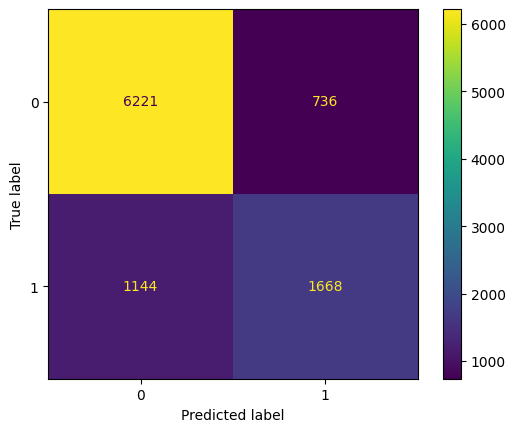

In [22]:
ConfusionMatrixDisplay.from_predictions(GaussianModel.predict(XtestGD),YtestGD)

# Multinomial Modeling 

In [23]:
MultinomialFeatures=["DiscreteAgeEncoded","DiscreteWorkingHourEncoded","educationEncoded","genderEncoded","educational-num","marital-statusEncoded","relationshipEncoded","raceEncoded"]
ExpectedValue=final_processed_data["incomeEncoded"]
MulinomialDf=final_processed_data[MultinomialFeatures]

In [24]:
trainpercent=80
trainlength=int(len(MulinomialDf)*0.8)

XtrainMN=MulinomialDf[0:trainlength]
YtrainMN=ExpectedValue[0:trainlength]

XtestMN=MulinomialDf[trainlength:]
YtestMN=ExpectedValue[trainlength:]

In [25]:
multinomialModel=MultinomialNB(alpha=10)

In [26]:
crossValidator(multinomialModel,XtrainMN,YtrainMN,4)

#######perfoming 4 Fold cross validation#######
Score for 1 th validation is :--  0.7803255195004607
Score for 2 th validation is :--  0.7800982800982801
Score for 3 th validation is :--  0.7766175266175266
Score for 4 th validation is :--  0.7732391482391482


In [27]:
multinomialModel.score(XtestMN,YtestMN)  ## Test score

0.7791995086498106

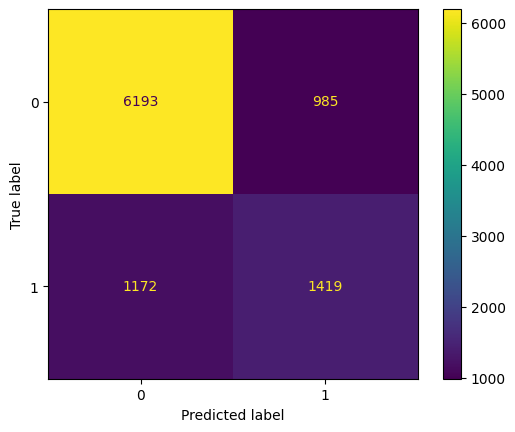

In [28]:
ConfusionMatrixDisplay.from_predictions(multinomialModel.predict(XtestMN),YtestMN)